In [119]:
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import scipy


In [156]:
# parameters
n_grids = 350 # number of grid in grid search
R = 500 # number of Monte Carlo steps

def set_parameters(r1, r2):
    global N, M, const
    N = len(r1) # sample size of F
    M = len(r2) # sample size of G
    const = ((N*M/(N+M))**0.5)

def create_grids(r1, r2):
    global income
    _min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
    _max = np.max([np.max(r1), np.max(r2)])
    income = np.linspace(_min, _max, n_grids) # grids

def draw_random_multipliers():
    global U1_tensor, U2_tensor
    U1 = stats.norm.rvs(size=(N, R))/20
    U1_tensor = tf.constant(np.repeat(U1[None, ...], n_grids, 0)) # repeat for grid search dimension

    U2 = stats.norm.rvs(size=(M, R))/20
    U2_tensor = tf.constant(np.repeat(U2[None, ...], n_grids, 0)) # repeat for grid search dimension

def create_tensors(r1, r2):
    global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    income_N_tensor = np.repeat(income[..., None], N, 1) # repeat for sample dimension
    income_N_tensor = np.repeat(income_N_tensor[..., None], R, 2) # repeat for MC dimension
    # income_N_tensor[0,0,0] == income_N_tensor[0,1,0] is True 
    # income_N_tensor[0,0,0] == income_N_tensor[0,0,1] is True 

    income_M_tensor = np.repeat(income[..., None], M, 1)
    income_M_tensor = np.repeat(income_M_tensor[..., None], R, 2)

    r1_tensor = np.repeat(r1[None, ...], n_grids, 0) # repeat for grid search dimension
    r1_tensor = np.repeat(r1_tensor[..., None], R, 2) # repeat for MC dimension
    r1_tensor = tf.constant(r1_tensor)

    r2_tensor = np.repeat(r2[None, ...], n_grids, 0)
    r2_tensor = np.repeat(r2_tensor[..., None], R, 2)
    r2_tensor = tf.constant(r2_tensor)


In [157]:
# Simple Numpy operation for S_hat 
def empirical_I(z, x, j):
    # x: one observation of the sample
    return (x <= z)*(z-x)**(j-1)/np.math.factorial(j-1)

def I(z, X, j):
    # Whole sample
    N = len(X)
    return 1/N*np.sum((X <= z)*(z-X)**(j-1))/np.math.factorial(j-1)

# Compute S_hat for given incomes r1 and r2
def S_hat_fn(r1, r2, j):
    global const, income
    fn = lambda z: (I(z, r2, j) - I(z, r1, j))
    a = np.array([fn(i) for i in income])
    
    S_hat1 = const*np.max(a)
    S_hat2 = -const*np.min(a)
    return S_hat1, S_hat2


In [158]:
# Make functions for Numpy adapt for Tensorflow Tensor
def empirical_I_tf(z, x, j):
    # x: one observation of the sample
    return tf.cast((x <= z), tf.float64)*tf.math.add(z, -x)**(j-1)/np.math.factorial(j-1)

def I_tf(z, X, j, N):
    # Whole sample
    A = tf.cast((X <= z), tf.float64)*tf.math.add(z, -X)**(j-1)
    A = tf.math.reduce_sum(A, axis=1, keepdims=True)
    A = tf.repeat(A, N, axis=1)
    return ((1/N)*A/np.math.factorial(j-1)).numpy()

def S_bar_fn(j):
    global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    a = empirical_I_tf(income_N_tensor, r1_tensor, j)
    b = I_tf(income_N_tensor, r1_tensor, j, N)

    c = empirical_I_tf(income_M_tensor, r2_tensor, j)
    d = I_tf(income_M_tensor, r2_tensor, j, M)

    e = ((c-d)*U2_tensor) - ((a-b)*U1_tensor)
    f = tf.math.reduce_sum(e, axis=1)

    S_bar1 = const*tf.math.reduce_max(f, axis=0)
    S_bar2 = -const*tf.math.reduce_min(f, axis=0)
    return S_bar1, S_bar2

In [159]:
def make_decision(S_bar, S_hat):
    p = np.mean(S_bar > S_hat) 
    print('P-value =', p)

    if p < 0.10:
        print("Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2")
        return 1
    else:
        print("Cannot reject Null; r2 is domaining r1 OR r2==r1")
        return 0

In [160]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [161]:
# import pickle
# with open('/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/v3_OOS_income.pickle', 'rb') as handle:
#     results = pickle.load(handle)

# Local
import pickle
with open('../Py_notebooks/static_results.pickle', 'rb') as handle:
    results = pickle.load(handle)

0.8814504777240854 1.9083406045227278


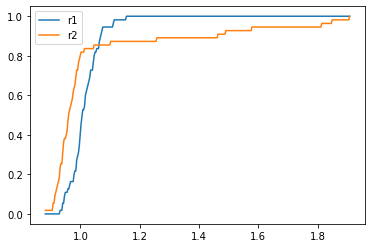

In [162]:
# two incomes
# r1 = (stats.t.rvs(df=10, size=350)*0.8)+3
# r2 = (stats.t.rvs(df=10, size=350)*1.2)+3.1

r1 = np.array(results[('Gumbel'), ('VaR 95%')])
# r1 = np.array(results[('future'), ('future')])

r2 = np.array(results[('Frank'), ('VaR 95%')])
# r2 = np.array(results[('Gaussian'), ('VaR q=0.05')])


ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label='r1')
plt.plot(x, ecdf2(x), label='r2')
plt.legend()

# test for SOSD
j = 1

In [163]:
try:
    del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
except: 
    pass

set_parameters(r1, r2)
create_grids(r1, r2)
S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

draw_random_multipliers()
create_tensors(r1, r2)
S_bar1, S_bar2 = S_bar_fn(j)

Ha = make_decision(S_bar1, S_hat1)
Hb = make_decision(S_bar2, S_hat2)

# sns.distplot(S_bar)

P-value = 0.12
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.834
Cannot reject Null; r2 is domaining r1 OR r2==r1


In [164]:
def run(r1, r2, j):
    try:
        del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    except: 
        pass

    set_parameters(r1, r2)
    create_grids(r1, r2)
    S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

    draw_random_multipliers()
    create_tensors(r1, r2)
    S_bar1, S_bar2 = S_bar_fn(j)

    Ha = make_decision(S_bar1, S_hat1)
    Hb = make_decision(S_bar2, S_hat2)
    return Ha, Hb

In [165]:
run(r1,r2,2)

P-value = 0.372
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.412
Cannot reject Null; r2 is domaining r1 OR r2==r1


(0, 0)

In [166]:
CR_pairs = list(results.keys()) # All Copula and Risk meausre pairs

In [167]:
# DONT RUN THE SECOND TIME!
print("Total number of operation is", len(CR_pairs)**2/2-len(CR_pairs))

SOSD = np.ones([len(CR_pairs), len(CR_pairs)])+1000
SOSD = pd.DataFrame(SOSD, index=CR_pairs, columns=CR_pairs)
# save_file = '/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/SOSD.pickle'
save_file = '../Py_notebooks/SOSD_static.pickle'

for i, pair1 in enumerate(CR_pairs):
    for k, pair2 in enumerate(CR_pairs):
        if (k<i) or (k==i):
            pass 
        else:
            r1 = np.array(results[pair1])
            r2 = np.array(results[pair2])
            SOSD.iloc[i,k], SOSD.iloc[k,i] = run(r1, r2, j=2)

            if (k%5 == 0):
                with open(save_file, 'wb') as handle:
                    pickle.dump(SOSD, handle)
            print(i,k)
            
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

Total number of operation is 1200.0
P-value = 0.832
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.708
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 1
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.584
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 2
P-value = 0.044
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.586
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 3
P-value = 0.038
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.62
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 4
P-value = 0.028
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.602
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 5
P-value = 0.038
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.59
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 6
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) O

P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.564
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 7
P-value = 0.042
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.602
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 8
P-value = 0.016
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.612
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 9
P-value = 0.044
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.6
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 10
P-value = 0.044
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.578
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 11
P-value = 0.056
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.588
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 12
P-value = 0.032
Reject Null; r2 is not domaining r1 (crossing) OR r1 is doma

P-value = 0.52
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.776
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 16
P-value = 0.604
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.238
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 17
P-value = 0.69
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.478
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 18
P-value = 0.762
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.596
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 19
P-value = 0.634
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.048
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
2 20
P-value = 0.612
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.038
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
2 21
P-value = 0.342
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.484
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 22
P-value = 0.602
C

P-value = 0.052
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.772
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 29
P-value = 0.066
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 30
P-value = 0.292
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 31
P-value = 0.8
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.25
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 32
P-value = 0.692
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.494
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 33
P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.35
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 34
P-value = 0.7
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.388
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 35
P-value = 0.786
Cannot

P-value = 0.714
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.548
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 44
P-value = 0.594
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.564
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 45
P-value = 0.792
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.558
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 46
P-value = 0.56
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.472
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 47
P-value = 0.696
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.562
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 48
P-value = 0.65
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.74
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 49
P-value = 0.802
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.31
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 6
P-value = 0.826
Cannot reject Null; r2 is domaining r1 OR r2

P-value = 0.564
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.172
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 17
P-value = 0.726
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.304
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 18
P-value = 0.804
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.444
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 19
P-value = 0.674
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.022
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
6 20
P-value = 0.576
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.034
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
6 21
P-value = 0.326
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.448
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 22
P-value = 0.574
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.034
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2


P-value = 0.67
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.524
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 34
P-value = 0.516
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.716
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 35
P-value = 0.752
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.608
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 36
P-value = 0.8
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.598
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 37
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.216
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 38
P-value = 0.57
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.27
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 39
P-value = 0.46
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.728
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 40
P-value = 0.52
Cannot reject Null; r2 is domaining r1 OR r2==

P-value = 0.786
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.296
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 13
P-value = 0.794
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.382
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 14
P-value = 0.652
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.47
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 15
P-value = 0.782
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.35
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 16
P-value = 0.634
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.08
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9 17
P-value = 0.82
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.164
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 18
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.268
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 19
P-value = 0.664
Cannot reject Null; r2 

P-value = 0.354
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.782
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 33
P-value = 0.53
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 34
P-value = 0.33
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.77
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 35
P-value = 0.436
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.724
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 36
P-value = 0.432
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.756
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 37
P-value = 0.758
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.34
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 38
P-value = 0.528
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.466
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 39
P-value = 0.294
Cannot reject Null; r2 is domaining 

P-value = 0.792
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.41
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 18
P-value = 0.738
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.602
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 19
P-value = 0.614
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.054
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
12 20
P-value = 0.642
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.032
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
12 21
P-value = 0.31
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.476
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 22
P-value = 0.61
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.034
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
12 23
P-value = 0.612
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.038
Reject Null; r2 is not domaining r1 (crossing)

P-value = 0.524
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.148
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 41
P-value = 0.68
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.476
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 42
P-value = 0.646
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 43
P-value = 0.722
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.3
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 44
P-value = 0.548
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.414
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 45
P-value = 0.764
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.31
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 46
P-value = 0.498
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.32
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 47
P-value = 0.626
Cannot reject Null; r2 is domaining r

P-value = 0.27
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.676
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 31
P-value = 0.84
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.308
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 32
P-value = 0.782
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.468
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 33
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.39
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 34
P-value = 0.756
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.422
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 35
P-value = 0.84
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.388
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 36
P-value = 0.776
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.45
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 37
P-value = 0.85
Cannot reject Null; r2 is domaining r1

P-value = 0.254
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.622
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 26
P-value = 0.01
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.776
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 27
P-value = 0.12
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.66
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 28
P-value = 0.016
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.784
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 29
P-value = 0.018
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.702
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 30
P-value = 0.04
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.594
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 31
P-value = 0.322
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.648
Cannot reject Null; r2 is d

P-value = 0.606
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.05
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
19 24
P-value = 0.632
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.036
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
19 25
P-value = 0.628
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.7
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 26
P-value = 0.034
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.842
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 27
P-value = 0.324
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 28
P-value = 0.028
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.76
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 29
P-value = 0.028
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.814
Cannot 

P-value = 0.836
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.53
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 24
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.696
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 25
P-value = 0.058
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.608
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 26
P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.678
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 27
P-value = 0.048
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.622
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 28
P-value = 0.01
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 29
P-value = 0.014
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.614
Canno

P-value = 0.042
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.618
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 28
P-value = 0.006
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.686
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 29
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.6
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 30
P-value = 0.018
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.564
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 31
P-value = 0.068
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.636
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 32
P-value = 0.042
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.6
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 33
P-value = 0.064
Reject Null; r2 is not domaining r1 (crossing) OR r1

P-value = 0.032
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.634
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 33
P-value = 0.05
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.616
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 34
P-value = 0.04
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.642
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 35
P-value = 0.036
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.672
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 36
P-value = 0.044
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.606
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 37
P-value = 0.112
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.594
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 38
P-value = 0.042
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P

P-value = 0.858
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.014
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
27 44
P-value = 0.656
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
27 45
P-value = 0.838
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.024
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
27 46
P-value = 0.618
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.006
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
27 47
P-value = 0.836
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.028
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
27 48
P-value = 0.828
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.022
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
27 49
P-value = 0.066
Reject Null; r2 is not domaining r1 (crossing) OR

P-value = 0.766
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.08
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
30 40
P-value = 0.524
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
30 41
P-value = 0.72
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.022
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
30 42
P-value = 0.778
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.034
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
30 43
P-value = 0.762
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.024
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
30 44
P-value = 0.578
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.016
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
30 45
P-value = 0.778
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-

P-value = 0.548
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.196
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 47
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.22
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 48
P-value = 0.798
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.326
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 49
P-value = 0.442
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.63
Cannot reject Null; r2 is domaining r1 OR r2==r1
34 35
P-value = 0.596
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.58
Cannot reject Null; r2 is domaining r1 OR r2==r1
34 36
P-value = 0.576
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.668
Cannot reject Null; r2 is domaining r1 OR r2==r1
34 37
P-value = 0.722
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.354
Cannot reject Null; r2 is domaining r1 OR r2==r1
34 38
P-value = 0.528
Cannot reject Null; r2 is domaining

P-value = 0.254
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.744
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 43
P-value = 0.616
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.8
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 44
P-value = 0.45
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.718
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 45
P-value = 0.578
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.746
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 46
P-value = 0.544
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.64
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 47
P-value = 0.466
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.82
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 48
P-value = 0.426
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.732
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 49
P-value = 0.208
Cannot reject Null; r2 is domaining r

P-value = 0.588
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.666
Cannot reject Null; r2 is domaining r1 OR r2==r1
48 49


In [143]:
SOSD

,"(unhedged, unhedged)","(future, future)","(Gaussian, Variance)","(Gaussian, VaR 99%)","(Gaussian, VaR 95%)","(Gaussian, ES 99%)","(Gaussian, ES 95%)","(Gaussian, Spectral 10)","(t_Copula_P, Variance)","(t_Copula_P, VaR 99%)",...,"(Gauss Mix Indep, VaR 95%)","(Gauss Mix Indep, ES 99%)","(Gauss Mix Indep, ES 95%)","(Gauss Mix Indep, Spectral 10)","(NIG Factor, Variance)","(NIG Factor, VaR 99%)","(NIG Factor, VaR 95%)","(NIG Factor, ES 99%)","(NIG Factor, ES 95%)","(NIG Factor, Spectral 10)"
"(unhedged, unhedged)",1001.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"(future, future)",0.0,1001.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"(Gaussian, Variance)",0.0,0.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, VaR 99%)",0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, VaR 95%)",0.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, ES 99%)",0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, ES 95%)",0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, Spectral 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(t_Copula_P, Variance)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(t_Copula_P, VaR 99%)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
len(r2)

55

In [33]:
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

0.8755050911574485 1.1242429199677781


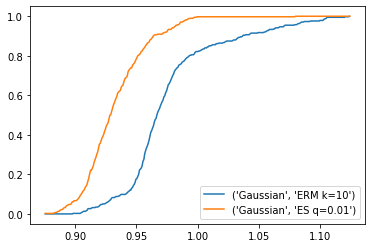

In [168]:
r1 = results[CR_pairs[0]]
r2 = results[CR_pairs[1]]
ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label=CR_pairs[0])
plt.plot(x, ecdf2(x), label=CR_pairs[1])
plt.legend()

In [17]:
pair1 = "(Frank, Variance)"

C1 = pair1[1:pair1.find(', ')]
R1 = pair1[pair1.find(', ')+2:-1]
pair1 = (C1, R1)

r1 = np.array(results[pair1])
r2 = np.ones(len(r1))
run(r1, r2, j=2)

P-value = 0.842
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2


(0, 1)

In [26]:
Ha_arr = []
Hb_arr = []

for i, pair1 in enumerate(CR_pairs):
    r1 = np.array(results[pair1])
    r2 = np.ones(len(r1))
    Ha, Hb = (run(r1, r2, j=2))
    Ha_arr.append(Ha)
    Hb_arr.append(Hb)
    print(pair1, Ha, Hb)

P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'ERM k=10') 0 1
P-value = 0.868
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'ES q=0.01') 0 1
P-value = 0.872
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'ES q=0.05') 0 1
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'VaR q=0.01') 0 1
P-value = 0.342
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.086
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'VaR q=0.05') 0 1
P-value = 0.852
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domai

P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('NIG_factor', 'VaR q=0.05') 0 1
P-value = 0.892
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('NIG_factor', 'Variance') 0 1


In [35]:
SOSD.loc['target', :] = Hb_arr + [1001]

In [36]:
SOSD.loc[:, 'target'] = Ha_arr + [1001]

In [37]:
SOSD

,"(Gaussian, ERM k=10)","(Gaussian, ES q=0.01)","(Gaussian, ES q=0.05)","(Gaussian, VaR q=0.01)","(Gaussian, VaR q=0.05)","(Gaussian, Variance)","(t_Copula, ERM k=10)","(t_Copula, ES q=0.01)","(t_Copula, ES q=0.05)","(t_Copula, VaR q=0.01)",...,"(Gauss Mix Indep, VaR q=0.01)","(Gauss Mix Indep, VaR q=0.05)","(Gauss Mix Indep, Variance)","(NIG_factor, ERM k=10)","(NIG_factor, ES q=0.01)","(NIG_factor, ES q=0.05)","(NIG_factor, VaR q=0.01)","(NIG_factor, VaR q=0.05)","(NIG_factor, Variance)",target
"(Gaussian, ERM k=10)",1001.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
"(Gaussian, ES q=0.01)",0.0,1001.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
"(Gaussian, ES q=0.05)",0.0,1.0,1001.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
"(Gaussian, VaR q=0.01)",0.0,1.0,0.0,1001.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
"(Gaussian, VaR q=0.05)",1.0,1.0,1.0,1.0,1001.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
"(Gaussian, Variance)",0.0,1.0,0.0,0.0,0.0,1001.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
"(t_Copula, ERM k=10)",0.0,1.0,0.0,0.0,0.0,0.0,1001.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
"(t_Copula, ES q=0.01)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
"(t_Copula, ES q=0.05)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1001.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
"(t_Copula, VaR q=0.01)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1001.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [38]:
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

In [41]:
[(Ha_arr[i], Hb_arr[i]) for i in range(len(Ha_arr))]

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]